In [172]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [173]:
x_min = -20000
x_max = +20000
x_num = 50

xV = np.linspace(x_min, x_max, x_num)

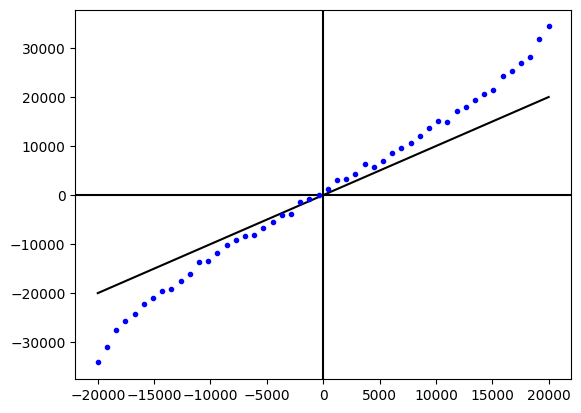

In [174]:
m = 1.3
b = 500

a = 50
T = 4000

n = 500

yV_lin = m * xV + b
yV_exp = np.sign(xV) * a * (np.exp(abs(xV)/T) - 1)
yV_noi = n * np.random.normal(size=xV.size)

yV = yV_lin + yV_exp + yV_noi

plt.axvline(x=0, color='k')
plt.axhline(y=0, color='k')
plt.plot(xV, xV, 'k')
plt.plot(xV, yV, '.b')


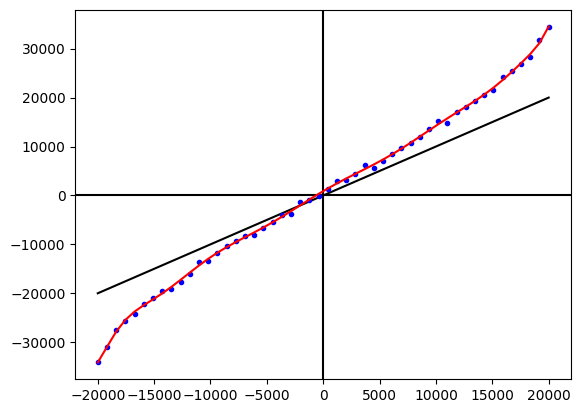

In [175]:
deg = 13

f = np.poly1d(np.polyfit(xV, yV, deg=deg))

plt.axvline(x=0, color='k')
plt.axhline(y=0, color='k')
plt.plot(xV, xV, 'k')
plt.plot(xV, yV, '.b')
plt.plot(xV, f(xV), 'r')

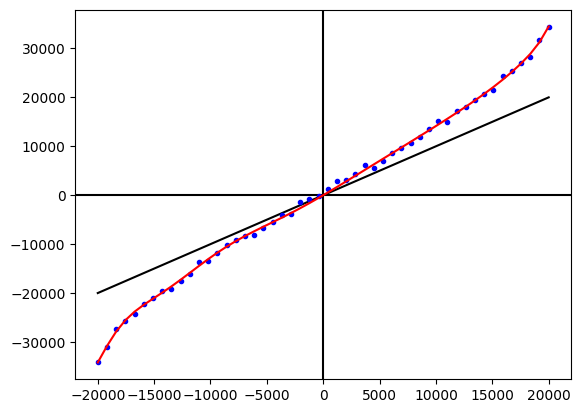

In [182]:
start_order = 1
stop_order = 13

xM = np.vstack([xV**i for i in range(start_order, stop_order+1, 1)]).T
coeff = np.linalg.solve(xM.T @ xM, xM.T @ yV)
yVp = xM @ coeff

plt.axvline(x=0, color='k')
plt.axhline(y=0, color='k')
plt.plot(xV, xV, 'k')
plt.plot(xV, yV, '.b')
plt.plot(xV, yVp, 'r')